**Re: On the PSF/kernel inference**

Enforcing positivity appears to be crucial. This is easily achieved in an iterative framework of steepest-descent. Some thought needs to be given as to how this might be translated into to a quasi-Newton optimisation; for now, don't bother with L-BFGS, and just stick to first-order optimisers like Adam.

In [1]:
import torch
import InferPSF
import InferPSF_Gaussian
import numpy as np
from astropy.io import fits
import os
from scipy.signal import convolve2d as conv
from scipy.special import i1 # modified bessel function of order 1
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

PyTorch version: 1.6.0
PyTorch version: 1.6.0


In [2]:
## for convenience, we'll apply a symmetric crop to all images
def crop(image, crop):
    return image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]

crop_size = 75

In [3]:
## first, let's grab the data
path = '/media/jah94/Seagate_Expansion_Drive#2/Reduction/OGLE_spools_test_2mins'
data = fits.getdata(os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.fits'))
data.shape

(10, 512, 512)

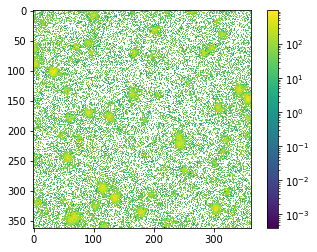

In [4]:
## top 1 percent of tli
scene = data[0]
#scene = fits.getdata(os.path.join(path, 'OGLE_000010.fits'))
scene = crop(scene, crop_size)
# sky subtract
scene -= np.median(scene)
plt.imshow(scene, norm=LogNorm())
plt.colorbar();

In [5]:
# now grab data image, y
#y = fits.getdata(os.path.join(path, 'OGLE_000010.fits'))
y = fits.getdata(os.path.join(path, 'OGLE_000100.fits'))
y.shape

(512, 512)

2.7641854


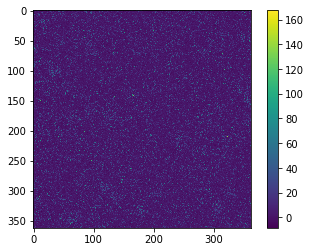

In [6]:
#y -= np.median(y)
#y += 1
y = crop(y, crop_size)
plt.imshow(y)#, norm=LogNorm())
plt.colorbar();
print(np.median(y))

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Probability distribution')

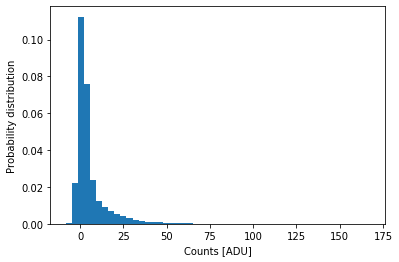

In [7]:
#print(np.min(y), np.max(y))
plt.hist(y.flatten(), bins=50, normed=True)[2]
plt.xlabel('Counts [ADU]')
plt.ylabel('Probability distribution')

In [8]:
# Poisson-Gamma-Normal likelihood
def PGN_likelihood(counts, n, f, gain, sigma, b0):
    g = f*(counts - b0)
    g_pos = g[g>=0]
    pdf_readout = np.exp(-n) * (1./np.sqrt(2*np.pi*sigma**2))*np.exp(-0.5*(g/sigma)**2)
    pdf_EM = np.exp(-n - (g_pos/gain)) * np.sqrt(n/(g_pos*gain)) * i1(2*np.sqrt((n*g_pos)/gain))
    pdf_pos = pdf_readout[g >= 0] + pdf_EM
    pdf_neg = pdf_readout[g < 0]
    pdf = f*np.concatenate((pdf_neg, pdf_pos)) # convert to 1/ADU = (e-_EM/ADU) * (1/e-_EM)
    return pdf

f, gain, sigma = 25.8, 300, 60
counts = np.linspace(-10, 70, 1000)
n = (f/gain)*np.mean(y) # Eq. 41
likelihood_no_bias = PGN_likelihood(counts, n, f, gain, sigma, 0)
likelihood_bias_correction = PGN_likelihood(counts, n, f, gain, sigma, 1.56)

/home/jah94/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, '$p(n_{ic}|\x08oldsymbol{\theta})$')

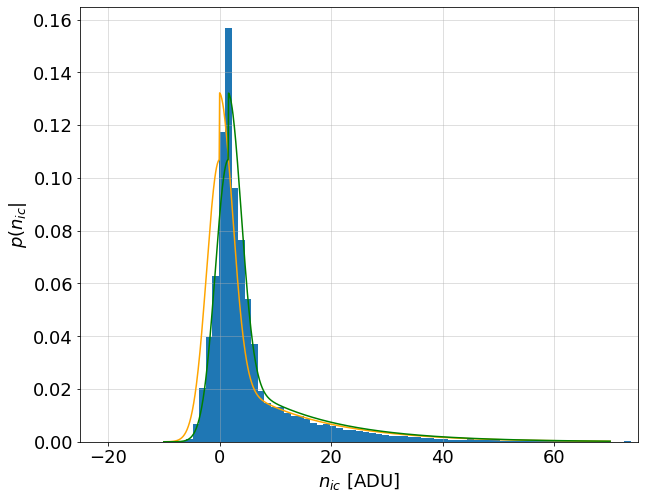

In [9]:

# histogram
#b = -1.67
b=0
fs = 18
plt.figure(figsize=(10, 8))
plt.hist(y.flatten() + b, normed=True, bins=150)[2]
plt.plot(counts, likelihood_no_bias, c='orange')
plt.plot(counts, likelihood_bias_correction, c='green') 
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(-25, 75)
#plt.vlines(2.75, 0, 0.16)
plt.grid(alpha=0.5)
plt.xlabel('$n_{ic}$ [ADU]', fontsize=fs)
plt.ylabel('$p(n_{ic}|\boldsymbol{\theta})$', fontsize=fs)


--- Time to move data onto GPU: 1.8130700588226318 ---
True
Check dtype of data and weights:
torch.float32 torch.float32 torch.float32 torch.float32
Check size of data and weights:
torch.Size([1, 1, 362, 362]) torch.Size([1, 1, 362, 362]) torch.Size([1, 1, 25, 25]) torch.Size([1])
Starting optimisation
Iteration:0, loss=402251.562500, P=0.000625
Parameter containing:
tensor([2.7641584873], device='cuda:0', requires_grad=True) tensor([1.5000000000], device='cuda:0', requires_grad=True)
Iteration:100, loss=399092.312500, P=0.038259
Parameter containing:
tensor([3.7600708008], device='cuda:0', requires_grad=True) tensor([1.5483236313], device='cuda:0', requires_grad=True)
Iteration:200, loss=399010.625000, P=0.038295
Parameter containing:
tensor([3.7025501728], device='cuda:0', requires_grad=True) tensor([1.6136087179], device='cuda:0', requires_grad=True)
Converged!
Total steps taken: 265
SD only
--- Finished kernel and background fit in 8.97670865058899 seconds ---
Photometric scaling: 

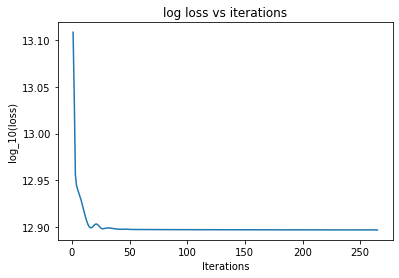

Not flipping kernel, as passed to torch.functional.conv2d
--- Finished in a total of 10.984874486923218 seconds ---


In [10]:
# sky subtract scene
#scene -= np.median(scene)
'''
kernel_gaussian, B0_gaussian = InferPSF_Gaussian.DIA(scene,
                         y+20,
                         np.ones(y.shape),
                         read_noise = 0.,
                         ks = 25,
                         lr_kernel = 1e-3,
                         lr_B = 1,
                         SD_steps = 100,
                         Newton_tol = 1e-6,
                         poly_degree=0,
                         fast=True,
                         tol = 1e-9,
                         max_iterations = 30000,
                         fisher=False,
                         show_convergence_plots=True)
'''

kernel_PGN, B0_PGN, offset, placeholder = InferPSF.DIA(scene,
                         y,
                         np.ones(y.shape),
                         read_noise = 0.,
                         ks = 25,
                         lr_kernel = 1e-3,
                         lr_B = 1,
                         Newton_tol = 1e-10,
                         poly_degree=0,
                         fast=True,
                         tol = 1e-9,
                         max_iterations = 1000,
                         positivity = True,
                         show_convergence_plots=True)


3.674942970275879 1.6579688787460327


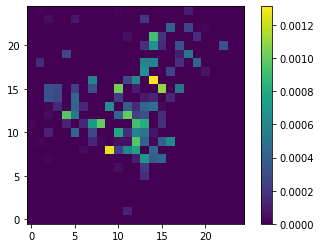

In [11]:
print(B0_PGN, offset)
# plot up the psf/kernel
plt.imshow(kernel_PGN, origin='lower')
plt.colorbar();

In [12]:
def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)
    
def convert_to_tensor(data):
    # converts np array to F32 tensor
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

Check kernel/psf orientations...

In [13]:
# torch.nn.functional.conv2d
prediction = torch.nn.functional.conv2d(convert_to_tensor(scene),
                                        convert_to_tensor(kernel_PGN),
                                        bias=None,
                                        padding=np.int(((25 - 1)/2))) 
prediction += torch.tensor(B0_PGN)

In [19]:
# scipy.signal.conv2d
prediction_np = conv(scene, kernel_PGN, mode='same') + B0_PGN
# scipy.signal.conv2d - placeholder is a flipped kernel, same as PyTorchDIA
# result of conv2d with this should be same as unflipped kenrel with torch.nn.functional.conv2d
prediction_sameorientation_np = conv(scene, placeholder, mode='same') + B0_PGN

In [21]:
save_numpy_as_fits(prediction.numpy() - y, 'torch_conv2d_pred.fits')
save_numpy_as_fits(prediction_sameorientation_np - y, 'scipy_conv2d_pred_sameastorch.fits')
save_numpy_as_fits(prediction_np - y, 'scipy_conv2d_pred.fits')